## 1. 데이터 로드 (CIFAR-10)

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_dataloader(batch_size=128, num_workers=4, pin_memory=True):
    """
    CIFAR-10 데이터 로드 함수. 데이터 전처리와 최적화를 포함.

    Args:
        batch_size (int): 배치 크기
        num_workers (int): DataLoader의 워커 수
        pin_memory (bool): GPU로 빠르게 전송을 위해 고정 메모리 사용 여부

    Returns:
        train_loader, test_loader
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
    ])

    # CIFAR-10 데이터셋 로드
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

    # DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    return train_loader, test_loader

## 2. 모델 정의 (CIFAR-10을 위한 모델)

In [2]:
from torchvision import models
import torch.nn as nn

def get_resnet_for_cifar10():
    """
    ResNet-18 모델을 CIFAR-10에 맞게 수정
    Returns:
        모델 객체
    """
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # CIFAR-10 크기에 맞게 수정
    model.maxpool = nn.Identity()  # 첫 번째 MaxPooling 제거
    model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 클래스 수에 맞게 출력 수정
    return model

## 3. Pruning 함수

In [11]:
import torch.nn.utils.prune as prune

def apply_unstructured_pruning(model, amount):
    """
    Unstructured Pruning: 지정된 비율만큼 가중치를 제거.
    """
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

def apply_structured_pruning(model, amount):
    """
    Structured Pruning: 지정된 비율만큼 가중치를 제거.
    """
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
    return model

def iterative_pruning_and_finetune(
    model,
    train_loader,
    test_loader,
    device,
    pruning_function,
    target_pruning_amount,
    step_pruning_amount,
    criterion,
    optimizer,
    finetune_epochs=5
):
    """
    Iterative Pruning과 Fine-tuning을 결합하여 점진적으로 Pruning 수행.

    Args:
        model (torch.nn.Module): Pruning 대상 모델
        train_loader (DataLoader): 학습 데이터 로더
        test_loader (DataLoader): 테스트 데이터 로더
        device (torch.device): 학습에 사용할 장치
        pruning_function (function): Pruning 함수 (Structured 또는 Unstructured)
        target_pruning_amount (float): 목표 Pruning 비율
        step_pruning_amount (float): 한 번에 Pruning할 비율
        criterion: Loss 함수
        optimizer: Optimizer
        finetune_epochs (int): Fine-tuning 수행 Epoch 수

    Returns:
        list: Iterative Pruning 과정에서의 성능 결과 리스트
    """
    current_pruning_ratio = 0
    current_remain_ratio = 1
    results = {}

    while current_pruning_ratio < target_pruning_amount:
        # Pruning 수행
        print(f"Applying pruning step with amount: {step_pruning_amount}")

        iter_step_pruning_ratio = step_pruning_amount / current_remain_ratio
        current_remain_ratio -= current_remain_ratio * iter_step_pruning_ratio

        iter_step_pruning_ratio = round(iter_step_pruning_ratio, 2)
        current_remain_ratio = round(current_remain_ratio, 2)
        print(f"Iterative target_pruning_amount: {iter_step_pruning_ratio}")

        pruning_function(model, iter_step_pruning_ratio)

        # Pruning 비율 갱신
        current_pruning_ratio = round(current_pruning_ratio + step_pruning_amount, 2)

        # Pruning 후 성능 평가
        val_loss, val_acc = evaluate(model, test_loader, device)
        print(f"Post-Pruning -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        # Fine-tuning 수행
        print(f"Fine-tuning model for {finetune_epochs} epochs...")
        for epoch in range(finetune_epochs):
            train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = evaluate(model, test_loader, device)
            print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

        # Fine-tuning 후 성능 평가
        final_loss, final_acc = evaluate(model, test_loader, device)
        print(f"Post-Fine-Tuning -> Loss: {final_loss:.4f}, Accuracy: {final_acc:.2f}%")

        # 결과 저장
        results[current_pruning_ratio] = (final_loss, final_acc)

        print(f"Current pruning ratio: {current_pruning_ratio}")

    return results

def evaluate_pruning(model, dataloader, device, prune_fn, amounts):
    results = {}

    # 모델 초기화
    model = get_resnet_for_cifar10().to(device)
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model.eval()

    for amount in amounts:
        pruned_model = prune_fn(model, amount=amount)
        pruned_loss, pruned_acc = evaluate(pruned_model, dataloader, device)
        results[amount] = (pruned_loss, pruned_acc)
        # 모델 초기화
        model = get_resnet_for_cifar10().to(device)
        model.load_state_dict(torch.load(best_model_path, weights_only=True))
        model.eval()
        print()
        print(f"Pruning amount: {amount}, Accuracy: {pruned_acc:.2f}%")
    return results

## 4. 학습 및 평가 함수

In [4]:
import torch

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [5]:
import torch

def save_checkpoint(model, filepath="best_model.pth"):
    """현재 모델 상태를 저장"""
    torch.save(model.state_dict(), filepath)

def load_checkpoint(model, filepath="best_model.pth"):
    """저장된 모델 상태를 불러오기"""
    model.load_state_dict(torch.load(filepath))
    return model

## 5. 학습 과정 시각화

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

class LivePlot:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def update(self, epoch, train_loss, train_acc, val_loss, val_acc):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(val_acc)

        # Colab에서는 출력 초기화 후 새로 그리기
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, label='Train Loss', color='blue')
        plt.plot(self.val_loss, label='Validation Loss', color='orange')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(self.train_acc, label='Train Accuracy', color='green')
        plt.plot(self.val_acc, label='Validation Accuracy', color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.title("Training and Validation Accuracy")
        plt.legend()

        plt.show()

In [7]:
import matplotlib.pyplot as plt

def plot_pruning_results(results, title="Pruning Results", output_path="pruning_results.png"):
    """
    Pruning 결과를 시각적으로 표현.
    Args:
        results (dict): Pruning 비율과 정확도가 포함된 결과
        title (str): 그래프 제목
        output_path (str): 저장할 파일 경로
    """
    amounts = list(results.keys())
    accuracies = list(acc for loss, acc in results.values())

    plt.figure(figsize=(10, 6))
    plt.plot(amounts, accuracies, marker='o', linestyle='-', color='blue', label="Accuracy")
    plt.ylim(0, 100)
    plt.xlabel("Pruning Amount")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.xticks(amounts)  # Pruning 비율을 x축에 표시
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.savefig(output_path)
    plt.show()

def plot_pruning_comparison(structured_results, unstructured_results, iterative_structured_results, iterative_unstructured_results, title="Pruning Comparison", output_path="pruning_comparison.png"):
    """
    Structured와 Unstructured Pruning 결과를 비교하는 그래프 생성.

    Args:
        structured_results (dict): Structured Pruning 결과 {pruning_amount: (loss, accuracy)}
        unstructured_results (dict): Unstructured Pruning 결과 {pruning_amount: (loss, accuracy)}
        title (str): 그래프 제목
        output_path (str): 그래프 저장 경로
    """
    # Pruning 비율
    pruning_amounts = list(structured_results.keys())

    # Structured Pruning 성능
    structured_accuracies = [structured_results[amount][1] for amount in pruning_amounts]

    # Unstructured Pruning 성능
    unstructured_accuracies = [unstructured_results[amount][1] for amount in pruning_amounts]

    # Iterative Structured Pruning 성능
    iter_structured_accuracies = [iterative_structured_results[amount][1] for amount in pruning_amounts]

    # Iterative Unstructured Pruning 성능
    iter_unstructured_accuracies = [iterative_unstructured_results[amount][1] for amount in pruning_amounts]

    # 그래프 생성
    plt.figure(figsize=(10, 6))
    plt.plot(pruning_amounts, structured_accuracies, marker='o', label="Structured Pruning", linestyle='-', color='blue')
    plt.plot(pruning_amounts, unstructured_accuracies, marker='o', label="Unstructured Pruning", linestyle='-', color='green')
    plt.plot(pruning_amounts, iter_structured_accuracies, marker='o', label="Iterative Structured Pruning", linestyle='-', color='red')
    plt.plot(pruning_amounts, iter_unstructured_accuracies, marker='o', label="Iterative Unstructured Pruning", linestyle='-', color='orange')

    # 그래프 설정
    plt.ylim(0, 100)
    plt.xlabel("Pruning Amount")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.xticks(pruning_amounts)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # 그래프 저장 및 표시
    plt.savefig(output_path)
    plt.show()

## 6. Main Workflow

### 6-1. 모델 학습

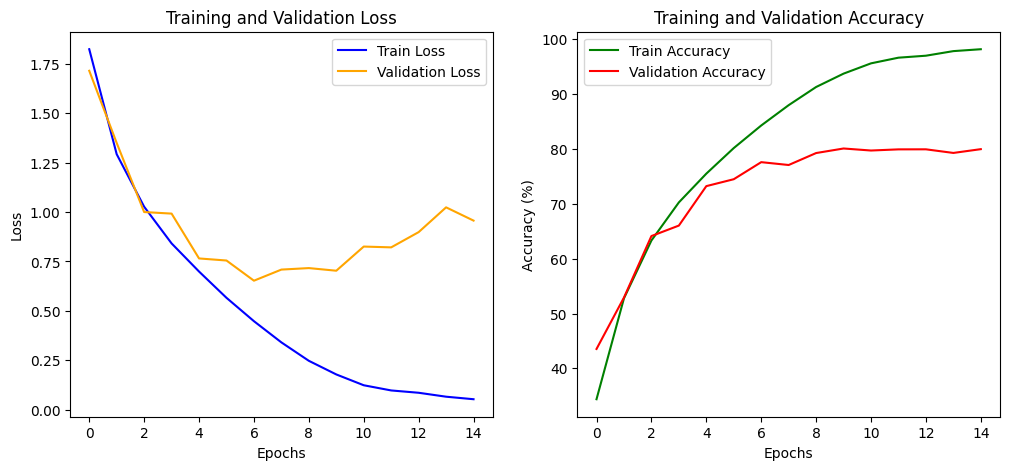

Epoch 15: Train Loss=0.0523, Train Acc=98.17%, Val Loss=0.9565, Val Acc=79.96%
Loading the best model with Val Acc=80.08%


<ipython-input-5-522acc76c371>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


In [8]:
# main.py
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드
batch_size = 256  # 최적 배치 크기
num_workers = 4  # 시스템의 CPU 코어 수에 맞게 조정
pin_memory = True  # GPU 사용 시 활성화

train_loader, test_loader = get_dataloader(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

# 모델 초기화
model = get_resnet_for_cifar10().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 실시간 시각화 초기화
live_plot = LivePlot()

# 최적의 모델 저장 변수 초기화
best_val_acc = 0.0
best_model_path = "best_model.pth"

print("Training initial model...")
for epoch in range(15):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, device)

    # 실시간 시각화 업데이트
    live_plot.update(epoch, train_loss, train_acc, val_loss, val_acc)

    print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

    # 최적의 모델 저장
    if val_acc > best_val_acc:
        print(f"New best model found at epoch {epoch + 1} with Val Acc={val_acc:.2f}%")
        best_val_acc = val_acc
        save_checkpoint(model, filepath=best_model_path)

# 최적의 모델 불러오기
print(f"Loading the best model with Val Acc={best_val_acc:.2f}%")
model = load_checkpoint(model, filepath=best_model_path)

### 6-2. Structured / Unstructured Pruning 평가

In [9]:
# Pruning 비율별 평가
pruning_amounts = [val/100 for val in range(5, 100, 5)]

print("Evaluating Unstructured Pruning...")
unstructured_results = evaluate_pruning(model, test_loader, device, apply_unstructured_pruning, pruning_amounts)
print(f"Unstructured Pruning Results: {unstructured_results}")

print("Evaluating Structured Pruning...")
structured_results = evaluate_pruning(model, test_loader, device, apply_structured_pruning, pruning_amounts)
print(f"Structured Pruning Results: {structured_results}")

Evaluating Unstructured Pruning...

Pruning amount: 0.05, Accuracy: 80.09%

Pruning amount: 0.1, Accuracy: 80.12%

Pruning amount: 0.15, Accuracy: 80.16%

Pruning amount: 0.2, Accuracy: 80.25%

Pruning amount: 0.25, Accuracy: 80.10%

Pruning amount: 0.3, Accuracy: 79.57%

Pruning amount: 0.35, Accuracy: 78.60%

Pruning amount: 0.4, Accuracy: 78.29%

Pruning amount: 0.45, Accuracy: 69.62%

Pruning amount: 0.5, Accuracy: 59.73%

Pruning amount: 0.55, Accuracy: 60.33%

Pruning amount: 0.6, Accuracy: 49.56%

Pruning amount: 0.65, Accuracy: 36.25%

Pruning amount: 0.7, Accuracy: 29.84%

Pruning amount: 0.75, Accuracy: 20.81%

Pruning amount: 0.8, Accuracy: 12.39%

Pruning amount: 0.85, Accuracy: 10.04%

Pruning amount: 0.9, Accuracy: 10.00%

Pruning amount: 0.95, Accuracy: 10.00%
Unstructured Pruning Results: {0.05: (0.701935729598999, 80.09), 0.1: (0.7015179649353027, 80.12), 0.15: (0.7031977001190186, 80.16), 0.2: (0.7000572686195373, 80.25), 0.25: (0.70514771900177, 80.1), 0.3: (0.725245

### 6-3. Iterative Pruning + Fine-tuning 평가

In [12]:
# Iterative Pruning 실행
target_pruning_amount = 0.95
step_pruning_amount = 0.05   # 한 번에 Pruning할 비율 (10%)
finetune_epochs = 1

print("Evaluating Unstructured Pruning + Fine tuning...")
unstructured_finetuning_results = iterative_pruning_and_finetune(
    model,
    train_loader,
    test_loader,
    device,
    apply_unstructured_pruning,  # Unstructured Pruning 함수
    target_pruning_amount=target_pruning_amount,
    step_pruning_amount=step_pruning_amount,
    criterion=criterion,
    optimizer=optimizer,
    finetune_epochs=finetune_epochs  # Fine-tuning Epoch 수
)
print(f"Unstructured Pruning + Fine tuning Results: {unstructured_finetuning_results}")
# plot_pruning_results(unstructured_results, title="Unstructured Pruning Results", output_path="unstructured_pruning_results.png")

# 모델 초기화
model = get_resnet_for_cifar10().to(device)
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

print("Evaluating Structured Pruning + Fine tuning...")
structured_finetuning_results = iterative_pruning_and_finetune(
    model,
    train_loader,
    test_loader,
    device,
    apply_structured_pruning,  # Unstructured Pruning 함수
    target_pruning_amount=target_pruning_amount,
    step_pruning_amount=step_pruning_amount,
    criterion=criterion,
    optimizer=optimizer,
    finetune_epochs=finetune_epochs  # Fine-tuning Epoch 수
)
print(f"Structured Pruning + Fine tuning Results: {structured_finetuning_results}")

Evaluating Unstructured Pruning + Fine tuning...
Applying pruning step with amount: 0.05
Iterative target_pruning_amount: 0.05
Post-Pruning -> Loss: 0.7019, Accuracy: 80.09%
Fine-tuning model for 1 epochs...
Epoch 1: Train Loss=0.1484, Train Acc=94.69%, Val Loss=0.8492, Val Acc=77.63%
Post-Fine-Tuning -> Loss: 0.8492, Accuracy: 77.63%
Current pruning ratio: 0.05
Applying pruning step with amount: 0.05
Iterative target_pruning_amount: 0.05
Post-Pruning -> Loss: 0.8566, Accuracy: 77.39%
Fine-tuning model for 1 epochs...
Epoch 1: Train Loss=0.1036, Train Acc=96.40%, Val Loss=0.8456, Val Acc=79.66%
Post-Fine-Tuning -> Loss: 0.8456, Accuracy: 79.66%
Current pruning ratio: 0.1
Applying pruning step with amount: 0.05
Iterative target_pruning_amount: 0.06
Post-Pruning -> Loss: 0.8471, Accuracy: 79.51%
Fine-tuning model for 1 epochs...
Epoch 1: Train Loss=0.0664, Train Acc=97.67%, Val Loss=0.9324, Val Acc=79.89%
Post-Fine-Tuning -> Loss: 0.9324, Accuracy: 79.89%
Current pruning ratio: 0.15
Appl

### 6-4. Pruning 결과 시각화


[Unstructured Pruning Results]


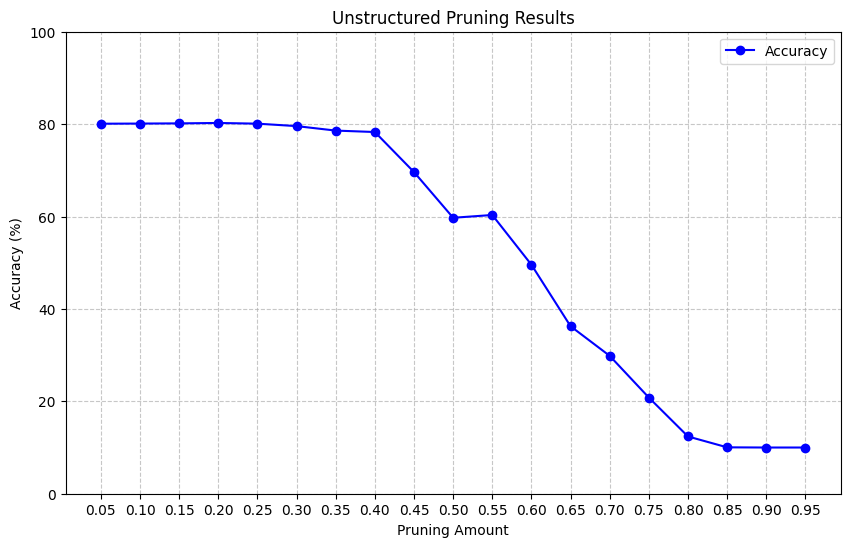

[Structured Pruning Results]


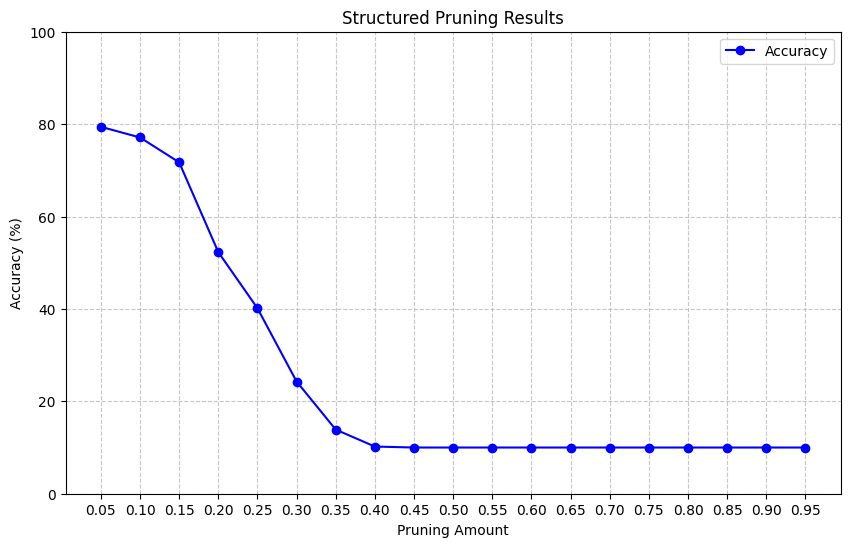

[Iterative Unstructured Pruning + Fine-tuning Results]


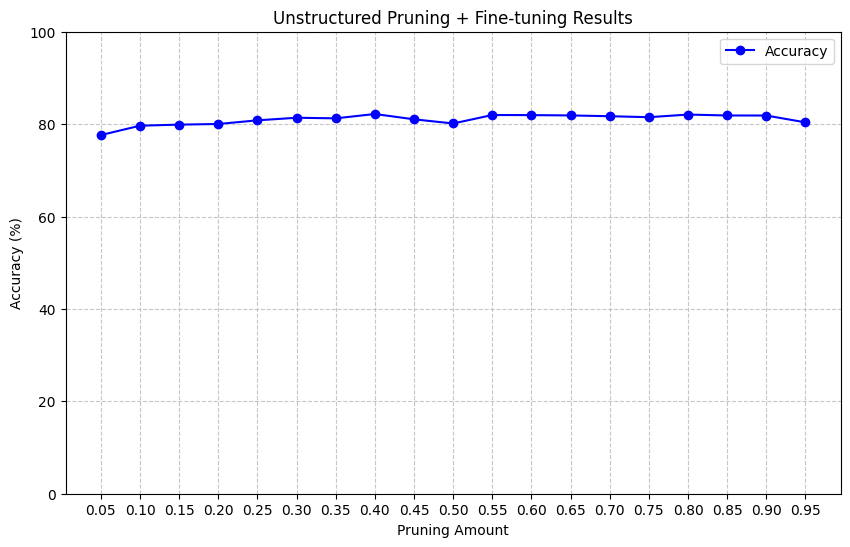

[Iterative Structured Pruning + Fine-tuning Results]


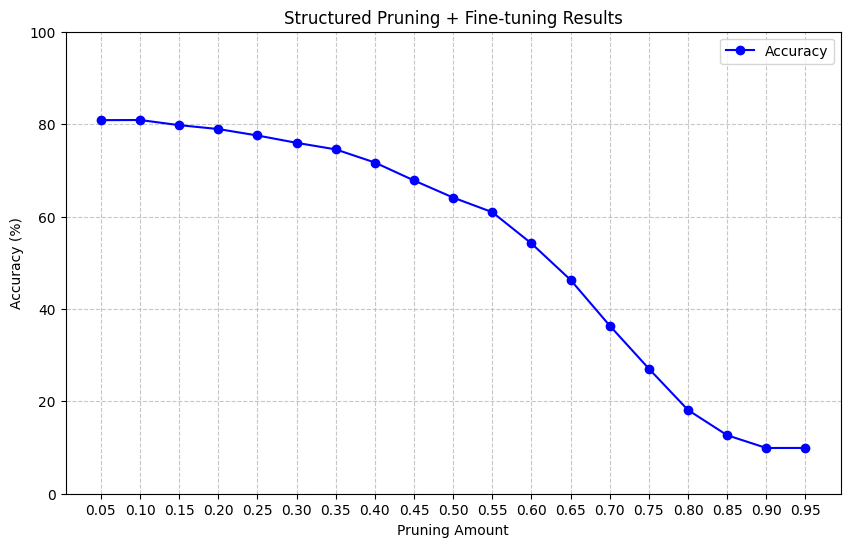

In [13]:
print("[Unstructured Pruning Results]")
plot_pruning_results(unstructured_results, title="Unstructured Pruning Results", output_path="unstructured_pruning_results.png")
print("[Structured Pruning Results]")
plot_pruning_results(structured_results, title="Structured Pruning Results", output_path="structured_pruning_results.png")
print("[Iterative Unstructured Pruning + Fine-tuning Results]")
plot_pruning_results(unstructured_finetuning_results, title="Unstructured Pruning + Fine-tuning Results", output_path="unstructured_finetuning_results.png")
print("[Iterative Structured Pruning + Fine-tuning Results]")
plot_pruning_results(structured_finetuning_results, title="Structured Pruning + Fine-tuning Results", output_path="structured_finetuning_results.png")

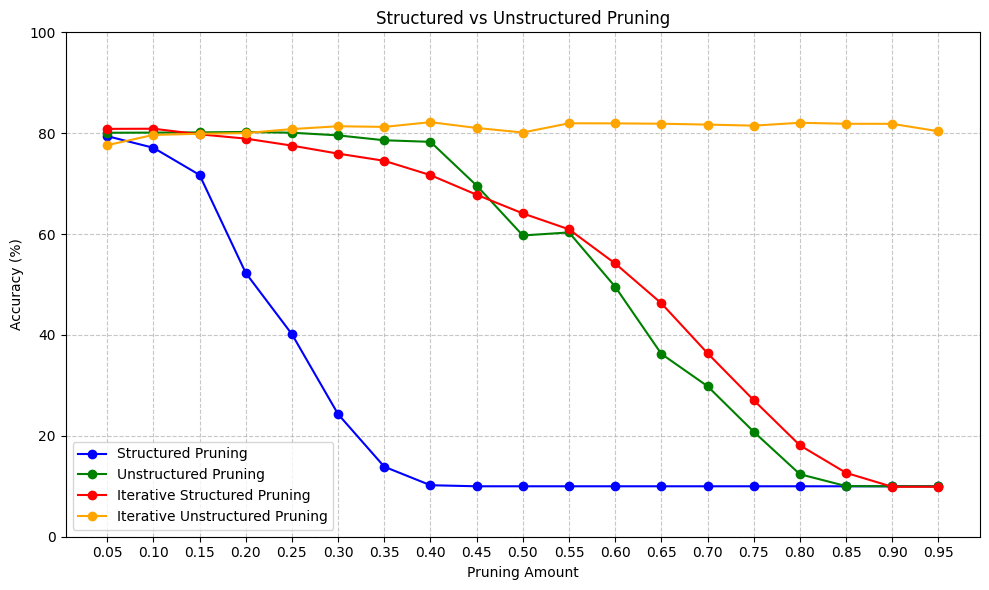

In [14]:
# Pruning 결과를 비교하는 그래프 생성
plot_pruning_comparison(
    structured_results=structured_results,
    unstructured_results=unstructured_results,
    iterative_structured_results=structured_finetuning_results,
    iterative_unstructured_results=unstructured_finetuning_results,
    title="Structured vs Unstructured Pruning",
    output_path="pruning_comparison.png"
)